In [1]:
import os
import pandas as pd
import numpy as np
import itertools
import numpy.typing as npt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


os.getcwd()
os.chdir("C:\\Users\\nathi\\Downloads\\3 Semester\\AMS\\")

In [2]:
def ts_train_test_split(
    ts: npt.ArrayLike, training_size: int
) -> tuple[pd.DataFrame, pd.DataFrame] | tuple[np.ndarray, np.ndarray]:
    """
    Time series train test split. Performs a single split of the series.

    Parameters:
    ----------
    ts: array-like
        univariate time series data set

    training_size: int
        Size of the training set. The test set length

    Returns:
    -------
    Tuple[pd.DataFrame, pd.DataFrame] | Tuple[np.ndarray, np.ndarray]
        A tuple containing the training and test sets,
        either as DataFrames or NumPy arrays
    """
    if training_size >= len(ts):
        raise ValueError("training_size must be < length of series")

    if isinstance(ts, pd.DataFrame):
        return ts.iloc[:training_size], ts.iloc[training_size:]

    return np.asarray(ts[:training_size]), np.asarray(ts[training_size:])

In [3]:
# pip install tensorflow

In [4]:
path = 'datasets_pseudo/Threshold/'
names = os.listdir(path)
dfs = {}

for name in names:
    machine, material, component, _ = name.replace('.csv', '').split('_')
    tempdf = pd.read_csv(f"{path}\\{name}", index_col=0) 
    # tempdf[['Machine', 'Material', 'Component']] = [machine, material, component]
    print(f"Size of {name}: {tempdf.shape}")

    dfs[name.replace('.csv', '')] = tempdf

df = pd.concat(dfs.values(), ignore_index=True)
display(df.head(5))

Size of threshold_CMX1_AL_CP1.csv: (433666, 63)
Size of threshold_CMX1_AL_CP2.csv: (74822, 63)
Size of threshold_CMX1_S_CP1.csv: (244772, 63)
Size of threshold_CMX1_S_CP2.csv: (45468, 63)
Size of threshold_DMC2_AL_CP1.csv: (510050, 63)
Size of threshold_DMC2_AL_CP2.csv: (64337, 63)
Size of threshold_DMC2_S_CP1.csv: (263913, 63)
Size of threshold_DMC2_S_CP2.csv: (42016, 63)


,LOAD|1,LOAD|2,LOAD|3,LOAD|6,ENC_POS|1,ENC_POS|2,ENC_POS|3,ENC_POS|6,CTRL_DIFF2|1,CTRL_DIFF2|2,...,CURRENT|2,CURRENT|3,CURRENT|6,Machine,Material,Component,CURRENT|1_Peak,CURRENT|2_Peak,CURRENT|3_Peak,CURRENT|6_Peak
0,3.857422,3.320312,24.230957,3.619385,-335.15767,-234.31094,-401.311863,527761.371165,0.013478,0.000203,...,-0.599854,4.352783,-1.017822,CMX1,AL,CP1,False,False,False,False
1,3.857422,3.320312,24.230957,3.619385,-335.15213,-234.31158,-401.311453,527783.573847,0.013601,0.001036,...,-0.640869,4.371582,-1.015137,CMX1,AL,CP1,False,False,False,False
2,4.199219,3.985596,24.212646,3.607178,-335.14666,-234.31181,-401.311073,527805.777216,0.013794,0.001459,...,-0.702393,4.357910,-1.015137,CMX1,AL,CP1,False,False,False,False
3,4.199219,3.985596,24.212646,3.607178,-335.14170,-234.31153,-401.311273,527827.979212,0.014498,0.001371,...,-0.712646,4.349365,-1.012451,CMX1,AL,CP1,False,False,False,False
4,4.907227,4.229736,24.291992,3.601074,-335.13690,-234.31128,-401.311323,527850.179835,0.015361,0.001312,...,-0.753662,4.371582,-1.009766,CMX1,AL,CP1,False,False,False,False


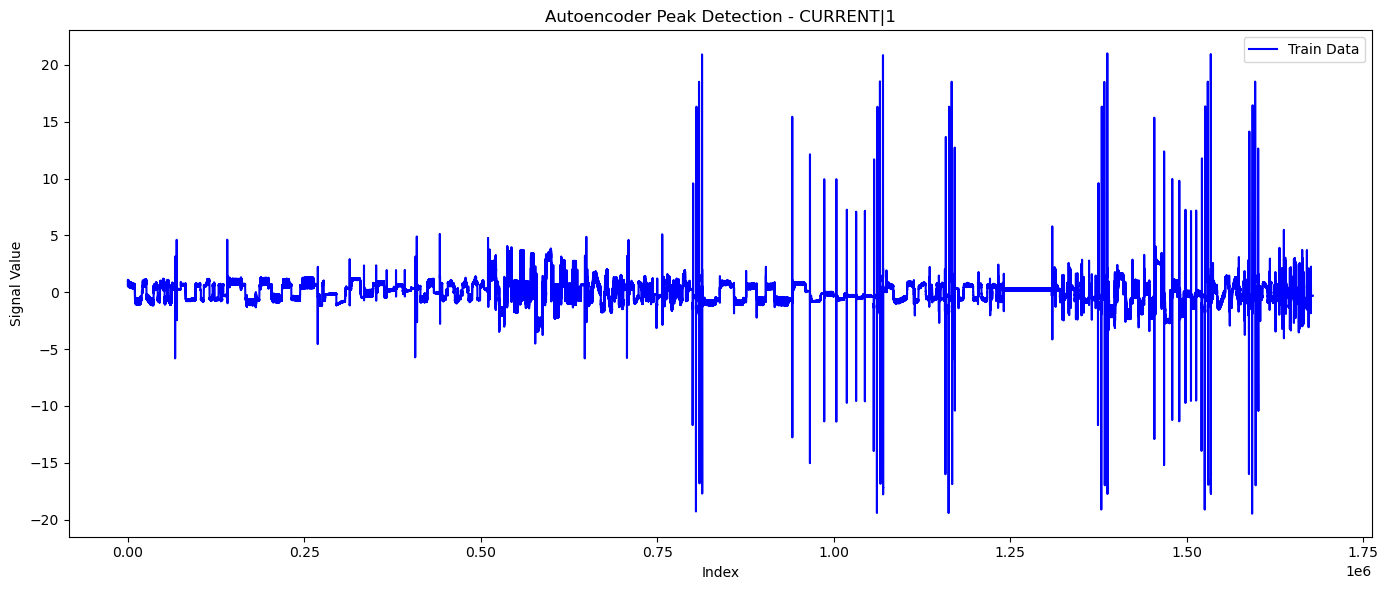

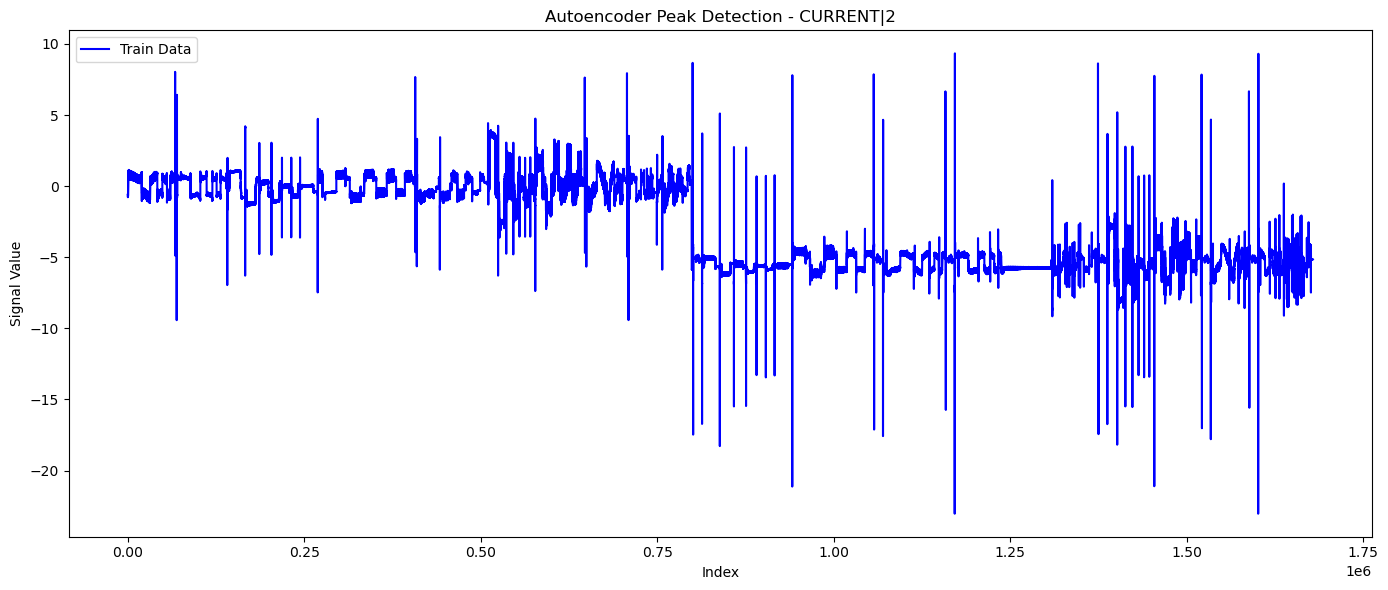

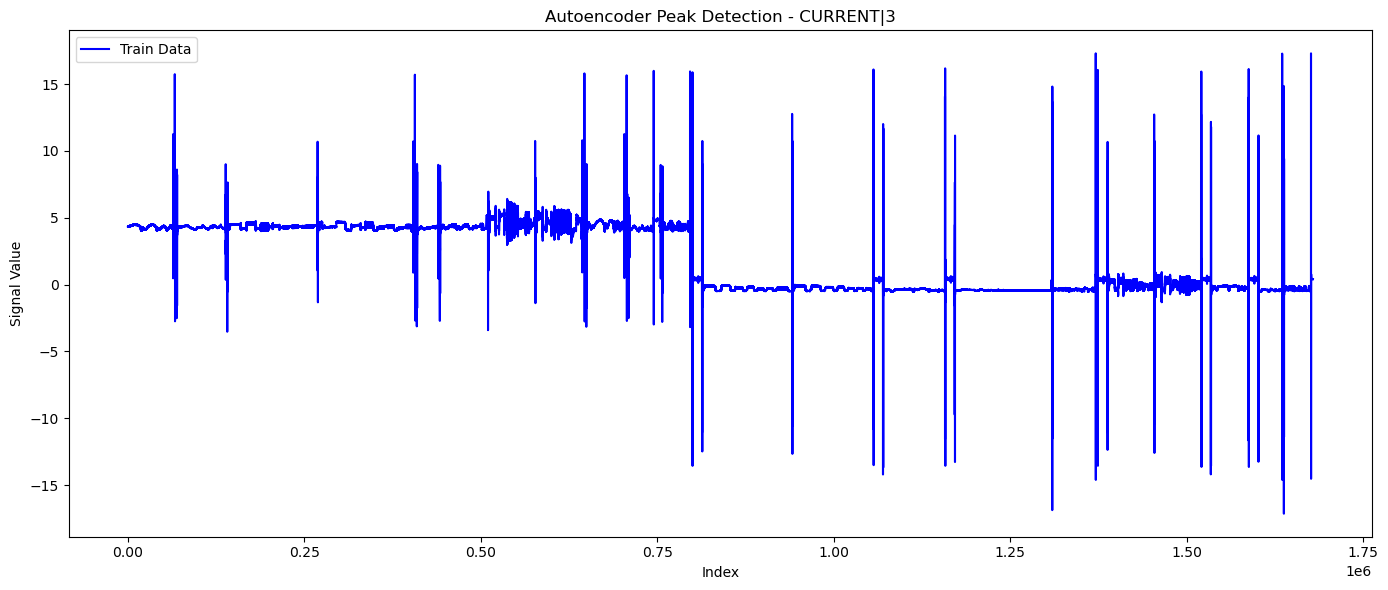

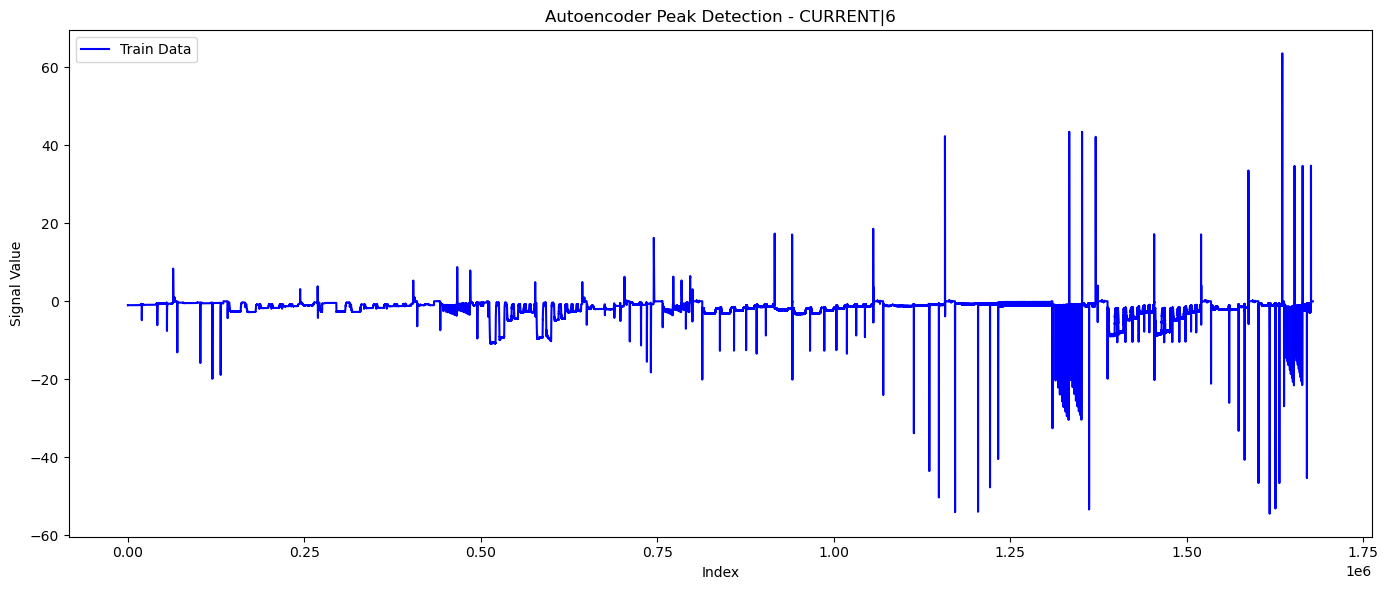

In [5]:
columns_to_predict = ['CURRENT|1', 'CURRENT|2', 'CURRENT|3', 'CURRENT|6']

for column in columns_to_predict:
    # Plotting section (optional: limit number of points for visibility)
    plot_column = column
    full_column_data = df[plot_column].values
    full_index = df.index


    plt.figure(figsize=(14, 6))
    plt.plot(full_index, full_column_data, label='Train Data', color='blue')


    plt.title(f'Autoencoder Peak Detection - {column}')
    plt.xlabel('Index')
    plt.ylabel('Signal Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Version 1
# columns_to_predict = ['CURRENT|1', 'CURRENT|2', 'CURRENT|3', 'CURRENT|6']
# latent_dims = [8]
# contamination_values = [0.005, 0.001, 0.01][-1:]

# feature_sets = {
#     'all_sensors': list(set(df.columns) - set(['Machine', 'Material', 'Component']) - set(['CURRENT|1_Peak', 'CURRENT|2_Peak', 'CURRENT|3_Peak', 'CURRENT|6_Peak'])), 
#     'torques' : ['TORQUE|1', 'TORQUE|2', 'TORQUE|3', 'TORQUE|6']
# }

# results = []

# # Loop through datasets
# for name in names:
#     df_filtered = pd.read_csv(f"{path}/{name}")

#     # Dynamically define all_sensors on first file
#     if feature_sets['all_sensors'] is None:
#         exclude = ['Machine', 'Material', 'Component'] + [f"{col}_Peak" for col in columns_to_predict]
#         feature_sets['all_sensors'] = list(set(df_filtered.columns) - set(exclude))

#     for column in columns_to_predict:
#         pseudo_label = f"{column}_Peak"
        
#         for feature_label, features in feature_sets.items():
#             features_copy = features.copy()
#             if column not in features_copy:
#                 features_copy.append(column)
                
#             data = df_filtered[features_copy + [pseudo_label]].dropna()
#             X_full = data[features_copy]
#             y_true = data[pseudo_label].astype(bool).values

#             # Scale inputs
#             scaler = MinMaxScaler()
#             X_scaled = scaler.fit_transform(X_full)

#             # Train-test split
#             train_size = round(0.5 * data.shape[0])
#             X_train, X_test = ts_train_test_split(X_scaled, train_size)
#             y_train, y_test = ts_train_test_split(y_true, train_size)
            
#             for latent_dim, contamination in itertools.product(latent_dims, contamination_values):
#                 # Build Autoencoder
#                 model = Sequential([
#                     Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
#                     Dense(latent_dim, activation='relu'),
#                     Dense(32, activation='relu'),
#                     Dense(X_train.shape[1], activation='linear')
#                 ])
                
#                 model.compile(optimizer='adam', loss='mse')

#                 model.fit(X_train, X_train, epochs=10, batch_size=256, verbose=0)

#                 # Predict and calculate reconstruction error
#                 reconstructed = model.predict(X_test)
#                 errors = np.mean((X_test - reconstructed) ** 2, axis=1)
#                 threshold = np.quantile(errors, 1 - contamination)
#                 y_pred = errors > threshold

#                 # Evaluation
#                 results.append({
#                     'Dataset': name.replace(".csv", ""), 
#                     'Column': column,
#                     'Features': feature_label,
#                     'Latent_Dim': latent_dim,
#                     'Contamination': contamination,
#                     'Accuracy': accuracy_score(y_test, y_pred),
#                     'Precision': precision_score(y_test, y_pred, zero_division=0),
#                     'Recall': recall_score(y_test, y_pred, zero_division=0),
#                     'F1': f1_score(y_test, y_pred, zero_division=0),
#                     'Detected_Peaks': np.sum(y_pred)
#                 })

#                 # Plotting section (optional: limit number of points for visibility)
#                 plot_column = column
#                 full_column_data = data[plot_column].values
#                 full_index = data.index

#                 # Plot only the test segment
#                 test_index = full_index[train_size:]
#                 test_values = full_column_data[train_size:]

#                 plt.figure(figsize=(14, 6))
#                 plt.plot(full_index, full_column_data, label='Train Data', color='blue')
#                 plt.plot(test_index, test_values, label='Test Data', color='green')

#                 # Plot predicted peaks
#                 peak_indices = np.array(test_index)[y_pred]
#                 peak_values = test_values[y_pred]

#                 plt.scatter(peak_indices, peak_values, color='red', label='Detected Peaks', zorder=5)

#                 plt.title(f'Autoencoder Peak Detection - {column} ({feature_label})')
#                 plt.xlabel('Index')
#                 plt.ylabel('Signal Value')
#                 plt.legend()
#                 plt.tight_layout()
#                 plt.show()

#     # Save and show results
#     results_df = pd.DataFrame(results)
#     results_df.sort_values(by='F1', ascending=False, inplace=True)
#     # results_df.to_csv(f"Results/AE_results_{name.replace(".csv", "")}.csv", index=False)
#     print(results_df.head(10))


Epoch 1/10


c:\Users\nathi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


848/848 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0038 - val_loss: 0.0055
Epoch 2/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 2.5665e-04 - val_loss: 0.0057
Epoch 3/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - loss: 1.6877e-04 - val_loss: 0.0051
Epoch 4/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 32s 37ms/step - loss: 1.3099e-04 - val_loss: 0.0076
Epoch 5/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - loss: 1.4763e-04 - val_loss: 0.0063
Epoch 6/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - loss: 9.7923e-05 - val_loss: 0.0069
Epoch 7/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - loss: 8.2975e-05 - val_loss: 0.0063
Epoch 8/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 6.9268e-05 - val_loss: 0.0068
Epoch 9/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 5.9708e-05 - val_loss: 0.0055
Epoch 10/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 5.6912e-05 - val_loss: 0.0050
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


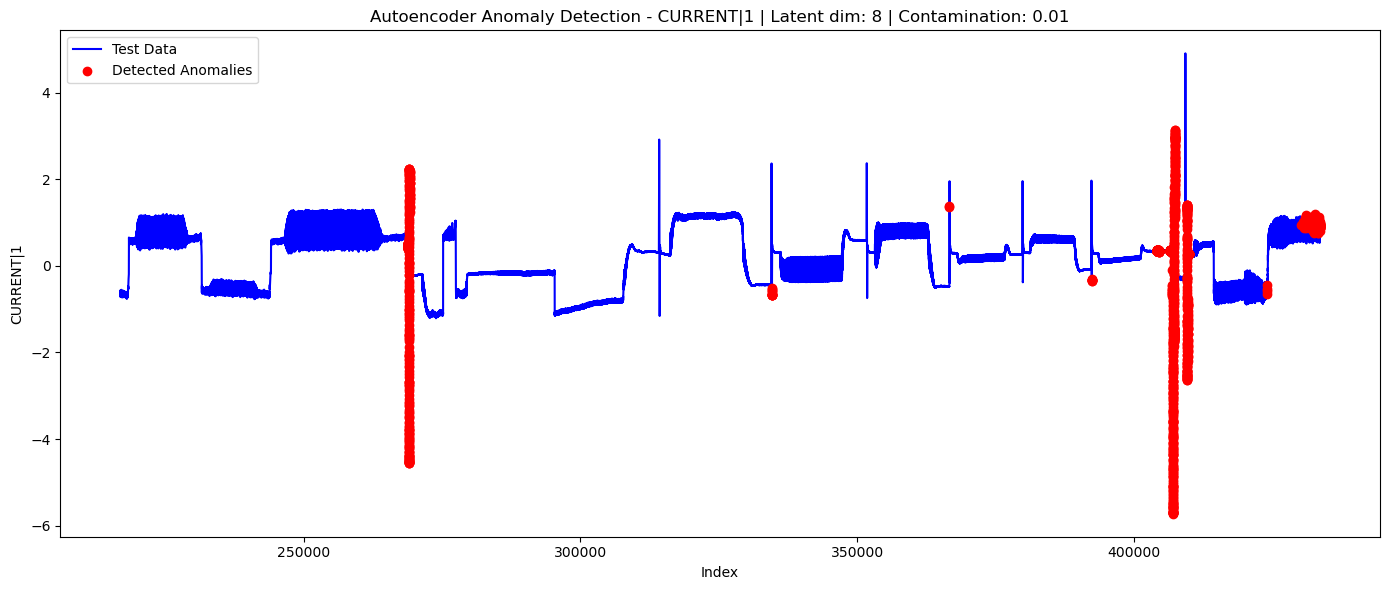

Epoch 1/10


c:\Users\nathi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


848/848 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 6.0111e-04 - val_loss: 4.0064e-05
Epoch 2/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 2.4311e-05 - val_loss: 3.5665e-05
Epoch 3/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 2.0182e-05 - val_loss: 3.8445e-04
Epoch 4/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 3.7573e-05 - val_loss: 4.0082e-05
Epoch 5/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.8883e-05 - val_loss: 1.9199e-05
Epoch 6/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 1.7642e-05 - val_loss: 2.9308e-05
Epoch 7/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.7334e-05 - val_loss: 3.3628e-05
Epoch 8/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 1.5505e-05 - val_loss: 1.4546e-05
Epoch 9/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - loss: 1.4659e-05 - val_loss: 7.0246e-05
Epoch 10/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.4761e-05 - val_loss: 2.8177e-05
6777/6777 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


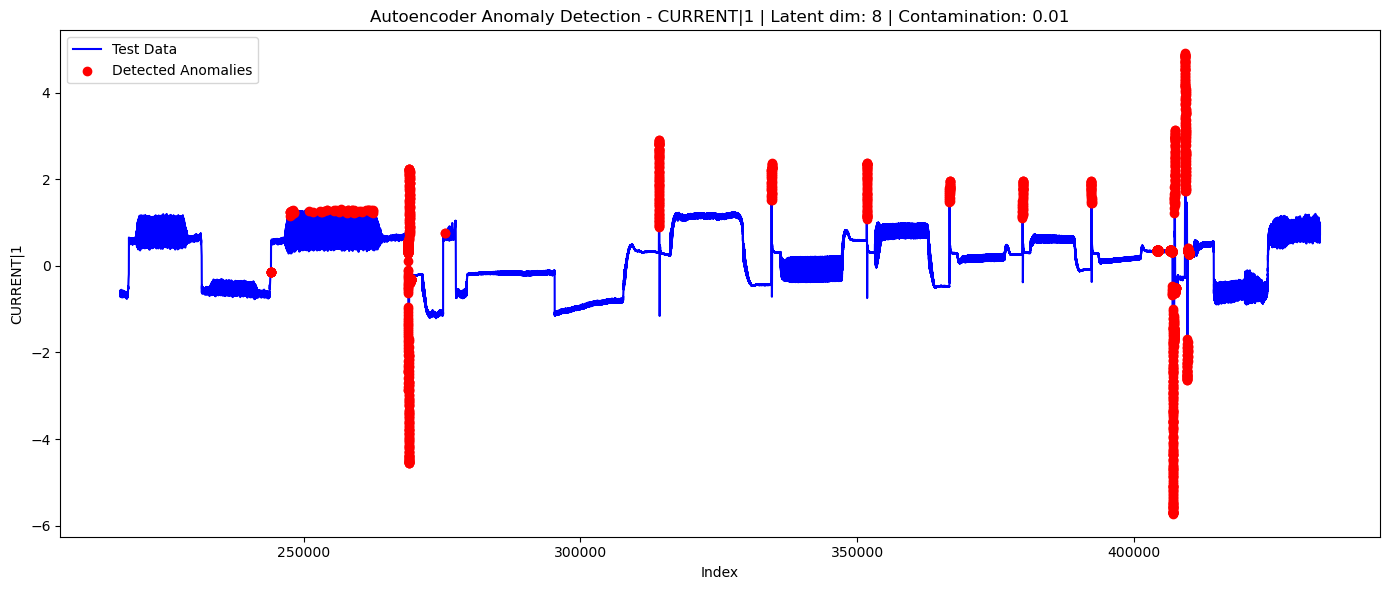

KeyError: 'F1'

In [ ]:

columns_to_predict = ['CURRENT|1', 'CURRENT|2', 'CURRENT|3', 'CURRENT|6']
latent_dims = [4, 8][-1:]
contamination_values = [0.005, 0.001, 0.01][-1:]

feature_sets = {
    'all_sensors': list(set(df.columns) - set(['Machine', 'Material', 'Component']) - set(['CURRENT|1_Peak', 'CURRENT|2_Peak', 'CURRENT|3_Peak', 'CURRENT|6_Peak'])), 
    'torques' : ['TORQUE|1', 'TORQUE|2', 'TORQUE|3', 'TORQUE|6']
}

results = []

# Loop through datasets
for name in names:
    df_filtered = pd.read_csv(f"{path}/{name}")

    # Dynamically define all_sensors on first file
    if feature_sets['all_sensors'] is None:
        exclude = ['Machine', 'Material', 'Component'] + [f"{col}_Peak" for col in columns_to_predict]
        feature_sets['all_sensors'] = list(set(df_filtered.columns) - set(exclude))

    for column in columns_to_predict:
        pseudo_label = f"{column}_Peak"
        
        for feature_label, features in feature_sets.items():
            features_copy = features.copy()
            if column not in features_copy:
                features_copy.append(column)
                
            data = df_filtered[features_copy + [pseudo_label]].dropna()
            X_full = data[features_copy]
            y_true = data[pseudo_label].astype(bool).values

            # Scale inputs
            scaler = MinMaxScaler()
            X_scaled = scaler.fit_transform(X_full)

            # Train-test split
            train_size = round(0.5 * data.shape[0])
            X_train, X_test = ts_train_test_split(X_scaled, train_size)
            y_train, y_test = ts_train_test_split(y_true, train_size)
            
            for latent_dim, contamination in itertools.product(latent_dims, contamination_values):
                # Build Autoencoder

                # 1. Build Autoencoder
                autoencoder = Sequential()
                autoencoder.add(Dense(512, activation='elu', input_shape=(X_train.shape[1],)))
                autoencoder.add(Dense(128, activation='elu'))
                autoencoder.add(Dense(latent_dim, activation='linear', name="bottleneck"))
                autoencoder.add(Dense(128, activation='elu'))
                autoencoder.add(Dense(512, activation='elu'))
                autoencoder.add(Dense(X_train.shape[1], activation='sigmoid'))
                autoencoder.compile(loss='mean_squared_error', optimizer=Adam())

                # 2. Train
                trained_model = autoencoder.fit(X_train, X_train,
                                                batch_size=64,
                                                epochs=50,
                                                verbose=1,
                                                validation_data=(X_test, X_test))

                # 3. Predict on test
                reconstructed = autoencoder.predict(X_test)
                errors = np.mean((X_test - reconstructed) ** 2, axis=1)
                threshold = np.quantile(errors, 1 - contamination)
                y_pred = errors > threshold  # Boolean array: True = anomaly

                # 4. Plot time series and anomalies
                test_index = data.index[train_size:]
                plot_column_values = data[column].values[train_size:]

                plt.figure(figsize=(14, 6))
                plt.plot(test_index, plot_column_values, label='Test Data', color='blue')

                # Plot detected anomalies
                anomaly_indices = test_index[y_pred]
                anomaly_values = plot_column_values[y_pred]
                plt.scatter(anomaly_indices, anomaly_values, color='red', label='Detected Anomalies', zorder=5)

                plt.title(f'Autoencoder Anomaly Detection - {column} | Latent dim: {latent_dim} | Contamination: {contamination}')
                plt.xlabel('Index')
                plt.ylabel(column)
                plt.legend()
                plt.tight_layout()
                plt.show()

            
                # autoencoder = Sequential()
                # autoencoder.add(Dense(512,  activation='elu', input_shape=(X_train.shape[1],)))
                # autoencoder.add(Dense(128,  activation='elu'))
                # autoencoder.add(Dense(latent_dim,    activation='linear', name="bottleneck"))
                # autoencoder.add(Dense(128,  activation='elu'))
                # autoencoder.add(Dense(512,  activation='elu'))
                # autoencoder.add(Dense(X_train.shape[1],  activation='sigmoid'))
                # autoencoder.compile(loss='mean_squared_error', optimizer = Adam())
                # trained_model = autoencoder.fit(X_train, X_train, batch_size=256, epochs=10, verbose=1, validation_data=(X_test, X_test))
                # encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
                # encoded_data = encoder.predict(X_train)  # bottleneck representation
                # decoded_output = autoencoder.predict(X_train)        # reconstruction
                # encoding_dim = 10

                # # return the decoder
                # encoded_input = Input(shape=(encoding_dim,))
                # decoder = autoencoder.layers[-3](encoded_input)
                # decoder = autoencoder.layers[-2](decoder)
                # decoder = autoencoder.layers[-1](decoder)
                # decoder = Model(encoded_input, decoder)

                # # Predict and calculate reconstruction error
                # reconstructed = model.predict(X_test)
                # errors = np.mean((X_test - reconstructed) ** 2, axis=1)
                # threshold = np.quantile(errors, 1 - contamination)
                # y_pred = errors > threshold

                # Evaluation
                results.append({
                    'Dataset': name.replace(".csv", ""), 
                    'Column': column,
                    'Features': feature_label,
                    'Latent_Dim': latent_dim,
                    'Contamination': contamination,
                    'Accuracy': accuracy_score(y_test, y_pred),
                    'Precision': precision_score(y_test, y_pred, zero_division=0),
                    'Recall': recall_score(y_test, y_pred, zero_division=0),
                    'F1': f1_score(y_test, y_pred, zero_division=0),
                    'Detected_Peaks': np.sum(y_pred)
                })

                # # Plotting section (optional: limit number of points for visibility)
                # plot_column = column
                # full_column_data = data[plot_column].values
                # full_index = data.index

                # # Plot only the test segment
                # test_index = full_index[train_size:]
                # test_values = full_column_data[train_size:]

                # plt.figure(figsize=(14, 6))
                # plt.plot(full_index, full_column_data, label='Train Data', color='blue')
                # plt.plot(test_index, test_values, label='Test Data', color='green')

                # # Plot predicted peaks
                # peak_indices = np.array(test_index)[y_pred]
                # peak_values = test_values[y_pred]

                # plt.scatter(peak_indices, peak_values, color='red', label='Detected Peaks', zorder=5)

                # plt.title(f'Autoencoder Peak Detection - {column} ({feature_label})')
                # plt.xlabel('Index')
                # plt.ylabel('Signal Value')
                # plt.legend()
                # plt.tight_layout()
                # plt.show()

    # Save and show results
    results_df = pd.DataFrame(results)
    results_df.sort_values(by='F1', ascending=False, inplace=True)
    results_df.to_csv(f"Results/AE_2_results_{name.replace(".csv", "")}.csv", index=False)
    print(results_df.head(10))
